In [2]:
import sys
import numpy as np
import pandas as pd
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import copy
from IPython.display import display
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions\
        import load_preproc_data_adult

#bias mitigation algorithms
from aif360.algorithms.preprocessing.reweighing import Reweighing
from aif360.algorithms.preprocessing.lfr import LFR
from aif360.algorithms.preprocessing.optim_preproc import OptimPreproc
from aif360.algorithms.preprocessing.optim_preproc_helpers.distortion_functions import get_distortion_adult
from aif360.algorithms.preprocessing.optim_preproc_helpers.opt_tools import OptTools
from aif360.algorithms.preprocessing.disparate_impact_remover import DisparateImpactRemover
#classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
#datasets
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions\
        import load_preproc_data_adult
from aif360.datasets import AdultDataset
from aif360.datasets import MEPSDataset19
from aif360.datasets import StandardDataset



# Ensure reproducibility
np.random.seed(1)

# Append a path if needed
sys.path.append("../")


pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'


In [3]:
def load_and_process_data(dataset_name, use_disparate_impact_remover=False):
    """
    Load and preprocess the dataset based on the name provided.
    Optionally, use DisparateImpactRemover based on the flag.
    """
    if dataset_name == 'adult':
        privileged_groups = [{'sex': 1}]
        unprivileged_groups = [{'sex': 0}]
        
        if use_disparate_impact_remover:
            # Use DisparateImpactRemover approach
            preprocessed_dataset = AdultDataset(
                protected_attribute_names=['sex'],
                privileged_classes=[['Male']],
                categorical_features=[],
                features_to_keep=['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
            )
        else:
            # Use the preprocessed dataset for ADULT with bias mitigation algorithms: Reweighing, LFR, OptimPreproc
            preprocessed_dataset = load_preproc_data_adult(['sex'])
        
        # Splitting the dataset
        train, val_test = preprocessed_dataset.split([0.7], shuffle=True, seed=42)
        val, test = val_test.split([0.5], shuffle=True, seed=42)
        
        return train, val, test, privileged_groups, unprivileged_groups
        

    elif dataset_name == 'meps':
        def preprocess_meps_dataset(meps_dataset, use_disparate_impact_remover=False):
            """
            Preprocess the MEPS dataset for AIF360, with the option to apply 
            DisparateImpactRemover and removing categorical features.
            """
            # Convert MEPSDataset19 to a DataFrame
            df, metadata = meps_dataset.convert_to_dataframe()

            # Clean invalid values for PCS42 and MCS42
            for col in ['PCS42', 'MCS42']:
                if col in df.columns:
                    # Replace negative values with NaN
                    df[col] = df[col].apply(lambda x: pd.NA if x < 0 else x)
                    # Fill NaN values with the column median
                    df[col] = df[col].fillna(df[col].median(skipna=True))

            df.rename(columns={'SEX=1': 'SEX'}, inplace=True)
            df['RACE'] = df['RACE'].replace({'White': 1.0, 'Non-White': 0.0})
            
            # Step 2: Handle scaling and feature renaming
            if use_disparate_impact_remover:
                # For DisparateImpactRemover: Remove categorical features
                # Retain only numerical features
                selected_columns = ['RACE', 'SEX', 'PCS42', 'MCS42', 'UTILIZATION']
                df = df[selected_columns]
            else:
                # For regular preprocessing: Retain categorical features (e.g., age groups)
                # Group age into decades
                df['Age (decade)'] = df['AGE'].apply(lambda x: min(x // 10 * 10, 70))
                # One-hot encode categorical columns
                categorical_columns = ['Age (decade)']
                df = pd.get_dummies(df, columns=categorical_columns)
                # Rename one-hot encoded columns to remove `.0` suffix
                df.rename(columns=lambda col: col.replace('.0', '') if 'Age (decade)' in col else col, inplace=True)
                # Dynamically retrieve column names for encoded categories
                age_decade_columns = [col for col in df.columns if 'Age (decade)_' in col]
                # Include new features (POVCAT and INSCOV)
                additional_features = [
                    'POVCAT=1', 'POVCAT=2', 'POVCAT=3', 'POVCAT=4', 'POVCAT=5',
                    'INSCOV=1', 'INSCOV=2', 'INSCOV=3'
                ]
                #Retain only necessary columns
                selected_columns = (
                    ['RACE', 'SEX', 'PCS42', 'MCS42'] +  # Include numerical and protected attributes
                    age_decade_columns +
                    additional_features +
                    ['UTILIZATION']  # Include target variable
                )
                df = df[selected_columns]

            # Create the processed AIF360 dataset
            processed_dataset = StandardDataset(
                df,
                label_name='UTILIZATION',
                favorable_classes=[1.0],
                protected_attribute_names=['RACE', 'SEX'],
                privileged_classes=[[1.0], [1.0]],  # Privileged groups: White and Male
            )

            return processed_dataset
                
   
        privileged_groups = [{'RACE': 1}]
        unprivileged_groups = [{'RACE': 0}]
        
        # Use the appropriate preprocessing based on whether DisparateImpactRemover is needed
        meps = MEPSDataset19()
        processed_meps = preprocess_meps_dataset(meps, use_disparate_impact_remover)

        # Splitting the MEPS dataset
        train, val_test = processed_meps.split([0.7], shuffle=True, seed=42)
        val, test = val_test.split([0.5], shuffle=True, seed=42)
        
        return train, val, test, privileged_groups, unprivileged_groups
            



In [4]:
#TODO: call MEPS for dir
#should test all of them
#these are the originals
train, val, test, privileged_groups, unprivileged_groups = load_and_process_data('adult', use_disparate_impact_remover=False)

In [5]:
def apply_bias_mitigation(method, train, test, unprivileged_groups, privileged_groups):
    
    if method == 'reweighing':
        reweighing = Reweighing(unprivileged_groups=unprivileged_groups,
                    privileged_groups=privileged_groups)
        reweighing.fit(train)
        train_transf = reweighing.transform(train)
        test_transf = reweighing.transform(test)
    
    elif method == 'lfr':
        lfr = LFR(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups,
                k=10, Ax=0.1, Ay=1.0, Az=1.5,
                verbose=1)
        train_transf = lfr.fit_transform(train)
        test_transf = lfr.transform(test)
    
    elif method == 'optimpreproc':
        optim_options = {
            "distortion_fun": get_distortion_adult,
            "epsilon": 0.05,
            "clist": [0.99, 1.99, 2.99],
            "dlist": [.1, 0.05, 0]
        } 

        optim_preproc = OptimPreproc(OptTools, optim_options,
                        unprivileged_groups = unprivileged_groups,
                        privileged_groups = privileged_groups)

        optim_preproc = optim_preproc.fit(train)
        train_transf = optim_preproc.transform(train)
        train_transf = train.align_datasets(train_transf)

        test_transf = optim_preproc.transform(test)
        test_transf = test.align_datasets(test_transf)
    
    elif method == 'disparateimpactremover':
        disp_impact_remover = DisparateImpactRemover(repair_level= 1.0, sensitive_attribute="sex")
        train_transf = disp_impact_remover.fit_transform(train)
        test_transf = disp_impact_remover.fit_transform(test)
    
    elif method == 'synthetic':
        # to be done later
        pass
    else:
        raise ValueError("Unsupported bias mitigation method. Choose from 'reweighing', 'lfr', 'optimpreproc', 'disparateimpactremover', 'synthetic'.")

    return train_transf, test_transf


In [6]:
# For Reweighing
train_transf, test_transf = apply_bias_mitigation('reweighing', train, test, unprivileged_groups, privileged_groups)

# For LFR
#train_transf, test_transf = apply_bias_mitigation('lfr', train, test, unprivileged_groups, privileged_groups)

# For OptimPreproc
#train_transf, test_transf = apply_bias_mitigation('optimpreproc', train, test, unprivileged_groups, privileged_groups)

# For DisparateImpactRemover
#train_transf, test_transf = apply_bias_mitigation('disparateimpactremover', train, test, unprivileged_groups, privileged_groups)


In [7]:
def evaluate_fairness_metrics(dataset, unprivileged_groups, privileged_groups, label="Dataset"):
    metric = BinaryLabelDatasetMetric(dataset, unprivileged_groups, privileged_groups)
    
    stat_parity_diff = f"{metric.mean_difference():.4f}"
    disp_impact = f"{metric.disparate_impact():.4f}"
    
    return stat_parity_diff, disp_impact

In [8]:
# Usage:
# Get the fairness metrics for each dataset
train_before_stat_parity_diff, train_before_disp_impact = evaluate_fairness_metrics(train, unprivileged_groups, privileged_groups, "Train Dataset (Before Transformation)")
test_before_stat_parity_diff, test_before_disp_impact = evaluate_fairness_metrics(test, unprivileged_groups, privileged_groups, "Test Dataset (Before Transformation)")

train_after_stat_parity_diff, train_after_disp_impact = evaluate_fairness_metrics(train_transf, unprivileged_groups, privileged_groups, "Train Dataset (After Transformation)")
test_after_stat_parity_diff, test_after_disp_impact = evaluate_fairness_metrics(test_transf, unprivileged_groups, privileged_groups, "Test Dataset (After Transformation)")

print("Train Dataset (Before Transformation) - Statistical Parity Difference:", train_before_stat_parity_diff)
print("Train Dataset (Before Transformation) - Disparate Impact:", train_before_disp_impact)
print("Test Dataset (Before Transformation) - Statistical Parity Difference:", test_before_stat_parity_diff)
print("Test Dataset (Before Transformation) - Disparate Impact:", test_before_disp_impact)

print("Train Dataset (After Transformation) - Statistical Parity Difference:", train_after_stat_parity_diff)
print("Train Dataset (After Transformation) - Disparate Impact:", train_after_disp_impact)
print("Test Dataset (After Transformation) - Statistical Parity Difference:", test_after_stat_parity_diff)
print("Test Dataset (After Transformation) - Disparate Impact:", test_after_disp_impact)


Train Dataset (Before Transformation) - Statistical Parity Difference: -0.1951
Train Dataset (Before Transformation) - Disparate Impact: 0.3572
Test Dataset (Before Transformation) - Statistical Parity Difference: -0.1893
Test Dataset (Before Transformation) - Disparate Impact: 0.3812
Train Dataset (After Transformation) - Statistical Parity Difference: 0.0000
Train Dataset (After Transformation) - Disparate Impact: 1.0000
Test Dataset (After Transformation) - Statistical Parity Difference: 0.0132
Test Dataset (After Transformation) - Disparate Impact: 1.0546


In [9]:

def train_classifier_and_find_best_threshold(train, val, classifier_type, unprivileged_groups, privileged_groups):

    
    # Select classifier
    if classifier_type == 'logistic_regression':
        #classifier = LogisticRegression(random_state=1, solver='liblinear', max_iter=1000)   #depends what logstic regression u use here
        #classifier = LogisticRegression(class_weight='balanced', solver='liblinear', random_state=1)
        classifier = LogisticRegression(random_state=1)


    elif classifier_type == 'random_forest':
        classifier = RandomForestClassifier(random_state=1)
    elif classifier_type == 'xgboost':
        classifier = XGBClassifier(random_state=1)
    else:
        raise ValueError("Invalid classifier type specified.")
    
    # Train the classifier on the training data
    classifier.fit(train.features, train.labels.ravel(), sample_weight=train.instance_weights)
    
    # Predict on the validation set
    val_scores = classifier.predict_proba(val.features)[:, 1]  # Only for the favorable class

    # Select best threshold for validation set
    thresholds = np.arange(0.01, 1, 0.01)
    val_balanced_accs = []

    for threshold in thresholds:
        val_LR_predictions = (val_scores >= threshold).astype(int)

        val_with_LR_scores = copy.deepcopy(val)
        val_with_LR_scores.labels = val_LR_predictions.reshape(-1, 1)  # Update labels with predictions

        val_metric = ClassificationMetric(val, val_with_LR_scores,
                                        unprivileged_groups=unprivileged_groups,
                                        privileged_groups=privileged_groups)
        balanced_acc = (val_metric.true_positive_rate() + val_metric.true_negative_rate()) / 2

        val_balanced_accs.append(balanced_acc)

    # Find the best threshold and associated balanced accuracy
    best_index = np.argmax(val_balanced_accs)
    best_threshold = thresholds[best_index]
    best_balanced_acc = val_balanced_accs[best_index]

    print(f"Best Threshold: {best_threshold}")
    print(f"Best Balanced Accuracy: {best_balanced_acc}")

    return classifier, best_threshold, best_balanced_acc

def apply_best_threshold_and_compute_metrics(classifier, test, best_threshold, unprivileged_groups, privileged_groups):
    # Apply the best threshold to the test set
    test_scores = classifier.predict_proba(test.features)[:, 1]
    test_LR_predictions= (test_scores >= best_threshold).astype(int)

    # Create a copy of the test dataset and set predicted labels
    test_with_LR_scores = copy.deepcopy(test)
    test_with_LR_scores.labels = test_LR_predictions.reshape(-1, 1)

    # Calculate fairness and performance metrics on the test set
    test_metric = ClassificationMetric(test, test_with_LR_scores,
                                    unprivileged_groups=unprivileged_groups,
                                    privileged_groups=privileged_groups)
    # Collect the metrics in a dictionary
    metrics = {
        'balanced_accuracy': (test_metric.true_positive_rate() + test_metric.true_negative_rate()) / 2,
        'statistical_parity_difference': test_metric.statistical_parity_difference(),
        'disparate_impact': test_metric.disparate_impact(),
        'average_odds_difference': test_metric.average_odds_difference(),
        'equal_opportunity_difference': test_metric.equal_opportunity_difference(),
        'theil_index': test_metric.theil_index()
    }

    # Print the metrics
    print(f"Balanced Accuracy (test): {metrics['balanced_accuracy']}")
    print(f"Statistical Parity Difference (test): {metrics['statistical_parity_difference']}")
    print(f"Disparate Impact (test): {metrics['disparate_impact']}")
    print(f"Average Odds Difference (test): {metrics['average_odds_difference']}")
    print(f"Equal Opportunity Difference (test): {metrics['equal_opportunity_difference']}")
    print(f"Theil Index (test): {metrics['theil_index']}")

    return metrics, test_scores

def plot_metrics(test, test_scores, best_threshold, unprivileged_groups, privileged_groups, thresholds=np.arange(0.01, 1, 0.01)):

    test_balanced_accs = []
    test_disp_impacts = []
    test_avg_odds_diffs = []

    for threshold in thresholds:
        test_predictions = (test_scores >= threshold).astype(int)
        test_with_scores = copy.deepcopy(test)
        test_with_scores.labels = test_predictions.reshape(-1, 1)

        # Compute fairness and performance metrics
        test_metric = ClassificationMetric(test, test_with_scores, unprivileged_groups, privileged_groups)
        
        test_balanced_accs.append((test_metric.true_positive_rate() + test_metric.true_negative_rate()) / 2)
        test_disp_impacts.append(test_metric.disparate_impact())
        test_avg_odds_diffs.append(test_metric.average_odds_difference())

    # Plot Balanced Accuracy and Fairness Metrics
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Balanced Accuracy
    ax1.plot(thresholds, test_balanced_accs, label="Balanced Accuracy", color="blue", linewidth=2)
    ax1.set_xlabel("Threshold", fontsize=14)
    ax1.set_ylabel("Balanced Accuracy", color="blue", fontsize=14)
    ax1.tick_params(axis='y', labelcolor="blue")
    ax1.grid()

    # Secondary y-axis for Disparate Impact and Average Odds Difference
    ax2 = ax1.twinx()
    ax2.plot(thresholds, test_disp_impacts, label="Disparate Impact", color="orange", linestyle="--", linewidth=2)
    ax2.plot(thresholds, test_avg_odds_diffs, label="Average Odds Difference", color="red", linestyle="-.", linewidth=2)

    ax2.set_ylabel("Fairness Metrics", color="red", fontsize=14)
    ax2.tick_params(axis='y', labelcolor="red")

    # Highlight the best threshold
    ax1.axvline(best_threshold, color='green', linestyle='--', linewidth=2, label="Best Threshold")

    # Combine legends from both axes
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    fig.legend(lines1 + lines2, labels1 + labels2, loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=3, fontsize=12)

    # Title and layout adjustments
    fig.suptitle("Test Metrics vs Threshold (transformed test data)", fontsize=16)
    fig.tight_layout()
    plt.show()




In [10]:
#now i need to modularize the function train classifier on transformed data
def train_classifier_on_transformed_data(train_transf, test_transf, classifier_type, best_threshold, unprivileged_groups, privileged_groups):
    # Select classifier
    if classifier_type == 'logistic_regression':
        #classifier = LogisticRegression(random_state=1, solver='liblinear', max_iter=1000)   # depends on which logistic regression you use here
        #classifier = LogisticRegression(class_weight='balanced', solver='liblinear', random_state=1)
        classifier = LogisticRegression(random_state=1)

    elif classifier_type == 'random_forest':
        classifier = RandomForestClassifier(random_state=1)
    elif classifier_type == 'xgboost':
        classifier = XGBClassifier(random_state=1)
    else:
        raise ValueError("Invalid classifier type specified.")
    
    # Train the classifier on the transformed training data
    classifier.fit(train_transf.features, train_transf.labels.ravel(), sample_weight=train_transf.instance_weights)
    
    # Apply the best threshold directly to the test set (transformed)
    test_scores = classifier.predict_proba(test_transf.features)[:, 1]
    test_LR_predictions = (test_scores >= best_threshold).astype(int)

    # Create a copy of the test dataset and set predicted labels
    test_with_LR_scores = copy.deepcopy(test_transf)
    test_with_LR_scores.labels = test_LR_predictions.reshape(-1, 1)

    # Calculate fairness and performance metrics on the transformed test set
    test_metric = ClassificationMetric(test_transf, test_with_LR_scores,
                                       unprivileged_groups=unprivileged_groups,
                                       privileged_groups=privileged_groups)
    
    metrics = {
        'balanced_accuracy': (test_metric.true_positive_rate() + test_metric.true_negative_rate()) / 2,
        'statistical_parity_difference': test_metric.statistical_parity_difference(),
        'disparate_impact': test_metric.disparate_impact(),
        'average_odds_difference': test_metric.average_odds_difference(),
        'equal_opportunity_difference': test_metric.equal_opportunity_difference(),
        'theil_index': test_metric.theil_index()
    }

    # Print the metrics
    print(f"Balanced Accuracy (test transformed): {metrics['balanced_accuracy']}")
    print(f"Statistical Parity Difference (test transformed): {metrics['statistical_parity_difference']}")
    print(f"Disparate Impact (test transformed): {metrics['disparate_impact']}")
    print(f"Average Odds Difference (test transformed): {metrics['average_odds_difference']}")
    print(f"Equal Opportunity Difference (test transformed): {metrics['equal_opportunity_difference']}")
    print(f"Theil Index (test transformed): {metrics['theil_index']}")

    return classifier, test_scores, metrics


In [11]:
def standardize_features(train, val, test):
    # Standardizing the features
    scaler = StandardScaler()
    train.features = scaler.fit_transform(train.features)
    val.features = scaler.transform(val.features)
    test.features = scaler.transform(test.features)
    
    return train, val, test


In [12]:
# Standardize the features (scaling)
train, val, test = standardize_features(train, val, test)

# Choose classifier type
classifier_type = 'logistic_regression'  # Change to 'random_forest' or 'xgboost'

# Step 1: Train classifier
classifier, best_threshold, best_balanced_acc = train_classifier_and_find_best_threshold(train, val, classifier_type, unprivileged_groups, privileged_groups)


Best Threshold: 0.22
Best Balanced Accuracy: 0.750658189919502


In [13]:
test_metrics, test_scores = apply_best_threshold_and_compute_metrics(classifier, test, best_threshold, unprivileged_groups, privileged_groups)

Balanced Accuracy (test): 0.7301993384418746
Statistical Parity Difference (test): -0.3952836868360807
Disparate Impact (test): 0.26208682736058364
Average Odds Difference (test): -0.34080102302051685
Equal Opportunity Difference (test): -0.36783535437222264
Theil Index (test): 0.11469950874717495


In [ ]:
def plot_metrics(test, test_scores, best_threshold, unprivileged_groups, privileged_groups, thresholds=np.arange(0.01, 1, 0.01)):

    test_balanced_accs = []
    test_disp_impacts = []
    test_avg_odds_diffs = []

    for threshold in thresholds:
        test_predictions = (test_scores >= threshold).astype(int)
        test_with_scores = copy.deepcopy(test)
        test_with_scores.labels = test_predictions.reshape(-1, 1)

        # Compute fairness and performance metrics
        test_metric = ClassificationMetric(test, test_with_scores, unprivileged_groups, privileged_groups)
        
        test_balanced_accs.append((test_metric.true_positive_rate() + test_metric.true_negative_rate()) / 2)
        test_disp_impacts.append(test_metric.disparate_impact())
        test_avg_odds_diffs.append(test_metric.average_odds_difference())

    # Plot Balanced Accuracy and Fairness Metrics
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Balanced Accuracy
    ax1.plot(thresholds, test_balanced_accs, label="Balanced Accuracy", color="blue", linewidth=2)
    ax1.set_xlabel("Threshold", fontsize=14)
    ax1.set_ylabel("Balanced Accuracy", color="blue", fontsize=14)
    ax1.tick_params(axis='y', labelcolor="blue")
    ax1.grid()

    # Secondary y-axis for Disparate Impact and Average Odds Difference
    ax2 = ax1.twinx()
    ax2.plot(thresholds, test_disp_impacts, label="Disparate Impact", color="orange", linestyle="--", linewidth=2)
    ax2.plot(thresholds, test_avg_odds_diffs, label="Average Odds Difference", color="red", linestyle="-.", linewidth=2)

    ax2.set_ylabel("Fairness Metrics", color="red", fontsize=14)
    ax2.tick_params(axis='y', labelcolor="red")

    # Highlight the best threshold
    ax1.axvline(best_threshold, color='green', linestyle='--', linewidth=2, label="Best Threshold")

    # Combine legends from both axes
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    fig.legend(lines1 + lines2, labels1 + labels2, loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=3, fontsize=12)

    # Title and layout adjustments
    fig.suptitle("Test Metrics vs Threshold (transformed test data)", fontsize=16)
    fig.tight_layout()
    plt.show()

In [ ]:
%matplotlib inline


c:\Users\festa\AppData\Local\Programs\Python\Python312\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)


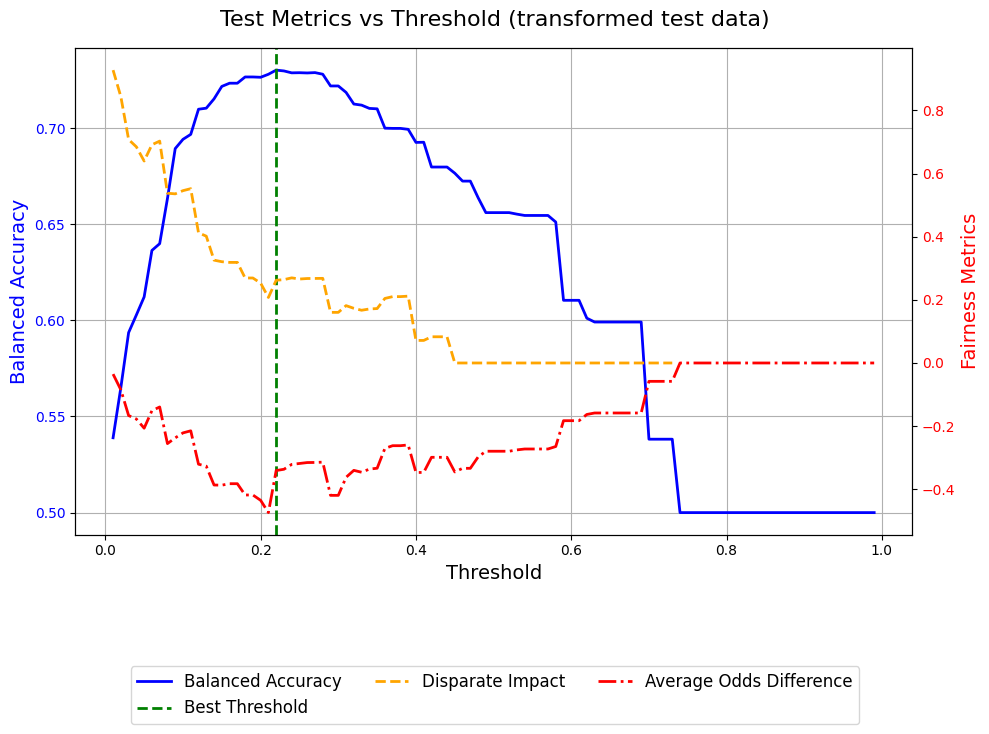

In [16]:
plot_metrics(test, test_scores, best_threshold, unprivileged_groups, privileged_groups)


In [ ]:
#somewhere here, a special treatment is needed for DIR and how we choose the best repair level.

Balanced Accuracy (test transformed): 0.7078205979911509
Statistical Parity Difference (test transformed): -0.01143584596876418
Disparate Impact (test transformed): 0.9759671958259325
Average Odds Difference (test transformed): -0.006045671631869115
Equal Opportunity Difference (test transformed): 0.015694433983580613
Theil Index (test transformed): 0.11151661002392621


c:\Users\festa\AppData\Local\Programs\Python\Python312\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)


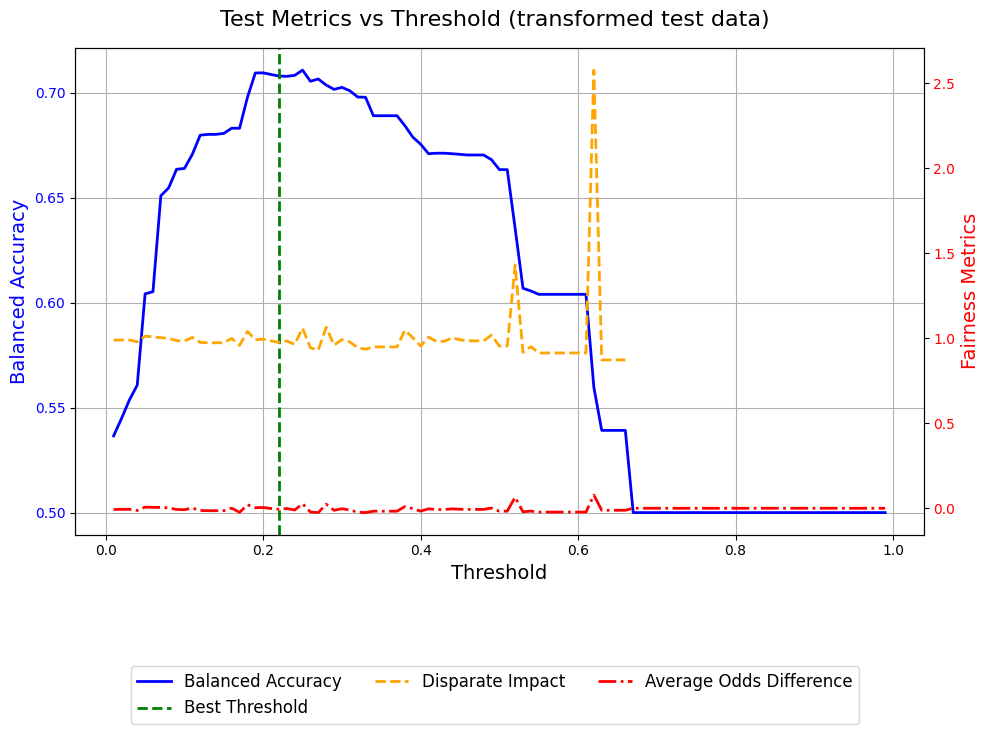

In [26]:
# Standardize the features (scaling)
train_transf, _ , test_transf = standardize_features(train_transf, val, test_transf)

# Train classifier on transformed data and use the same threshold
classifier_type = 'logistic_regression'  # Change to 'random_forest' or 'xgboost'
test_transf_classifier, test_transf_scores, test_transf_metrics = train_classifier_on_transformed_data(
    train_transf, test_transf, classifier_type, best_threshold, unprivileged_groups, privileged_groups)

# Plot metrics for transformed test data
plot_metrics(test_transf, test_transf_scores, best_threshold, unprivileged_groups, privileged_groups)

now they are transformed and we train logistic regression on trained data. TRAIN classifier with transformed data.

In [ ]:
#all that is left is to modularize this part

In [ ]:

def extract_fairness_metrics(
    train_before_stat_parity_diff, train_after_stat_parity_diff,
    test_before_stat_parity_diff, test_after_stat_parity_diff,
    train_before_disp_impact, train_after_disp_impact,
    test_before_disp_impact, test_after_disp_impact,
    best_threshold, best_balanced_acc,
    test_metrics, test_transf_metrics
):
    # Extract the fairness metrics before and after transformation from the given test metrics
    balanced_accuracy = test_metrics['balanced_accuracy']
    statistical_parity_difference = test_metrics['statistical_parity_difference']
    disparate_impact = test_metrics['disparate_impact']
    average_odds_difference = test_metrics['average_odds_difference']
    equal_opportunity_difference = test_metrics['equal_opportunity_difference']
    theil_index = test_metrics['theil_index']

    # Extract the fairness metrics for transformed data
    balanced_accuracy_transf = test_transf_metrics['balanced_accuracy']
    statistical_parity_difference_transf = test_transf_metrics['statistical_parity_difference']
    disparate_impact_transf = test_transf_metrics['disparate_impact']
    average_odds_difference_transf = test_transf_metrics['average_odds_difference']
    equal_opportunity_difference_transf = test_transf_metrics['equal_opportunity_difference']
    theil_index_transf = test_transf_metrics['theil_index']

    # Organizing the metrics with actual calculated values
    results_data = {
        "Dataset": [
            "Train", "Train", "Test", "Test", 
            "Train", "Train", "Test", "Test", 
            "Validation", "Validation", 
            "Test (Original)", "Test (Transformed)",
            "Test (Original)", "Test (Transformed)",
            "Test (Original)", "Test (Transformed)",
            "Test (Original)", "Test (Transformed)",
            "Test (Original)", "Test (Transformed)",
            "Test (Original)", "Test (Transformed)"
        ],
        "Stage": [
            "Before Transformation", "After Transformation", 
            "Before Transformation", "After Transformation",
            "Before Transformation", "After Transformation", 
            "Before Transformation", "After Transformation",
            "Best Threshold (Validation)", "Best Threshold (Validation)",
            "After Threshold", "After Threshold", 
            "After Threshold", "After Threshold", 
            "After Threshold", "After Threshold", 
            "After Threshold", "After Threshold", 
            "After Threshold", "After Threshold", 
            "After Threshold", "After Threshold"
        ],
        "Metric": [
            "Statistical Parity Difference", "Statistical Parity Difference",
            "Statistical Parity Difference", "Statistical Parity Difference",
            "Disparate Impact", "Disparate Impact",
            "Disparate Impact", "Disparate Impact",
            "Threshold", "Balanced Accuracy",
            "Balanced Accuracy", "Balanced Accuracy", 
            "Statistical Parity Difference", "Statistical Parity Difference", 
            "Disparate Impact", "Disparate Impact",
            "Average Odds Difference", "Average Odds Difference",
            "Equal Opportunity Difference", "Equal Opportunity Difference", 
            "Theil Index", "Theil Index"
        ],
        "Value": [
            float(train_before_stat_parity_diff),  # Statistical Parity Difference for Train (Before)
            float(train_after_stat_parity_diff),   # Statistical Parity Difference for Train (After)
            float(test_before_stat_parity_diff),  # Statistical Parity Difference for Test (Before)
            float(test_after_stat_parity_diff),   # Statistical Parity Difference for Test (After)
            float(train_before_disp_impact),      # Disparate Impact for Train (Before)
            float(train_after_disp_impact),       # Disparate Impact for Train (After)
            float(test_before_disp_impact),       # Disparate Impact for Test (Before)
            float(test_after_disp_impact),         # Disparate Impact for Test (After)
            best_threshold,
            best_balanced_acc,
            balanced_accuracy, 
            balanced_accuracy_transf,
            statistical_parity_difference, 
            statistical_parity_difference_transf,
            disparate_impact, 
            disparate_impact_transf,
            average_odds_difference, 
            average_odds_difference_transf,
            equal_opportunity_difference, 
            equal_opportunity_difference_transf,
            theil_index, 
            theil_index_transf
        ]
    }

    # Create the DataFrame
    results_table = pd.DataFrame(results_data)

    # Separate the data into three groups
    fairness_metrics = results_table.iloc[0:8].reset_index(drop=True)
    validation_metrics = results_table.iloc[8:10].reset_index(drop=True)
    test_metrics = results_table.iloc[10:22].reset_index(drop=True)

    # Name the tables
    fairness_metrics.name = "Fairness Metrics Before and After Transformation"
    validation_metrics.name = "Validation Metrics for Threshold Selection"
    test_metrics.name = "Test Metrics After Applying Threshold On Original and Transformed"

    # Display the tables with their names
    return fairness_metrics, validation_metrics, test_metrics


In [28]:
fairness_metrics, validation_metrics, test_metrics = extract_fairness_metrics(
    train_before_stat_parity_diff, train_after_stat_parity_diff,
    test_before_stat_parity_diff, test_after_stat_parity_diff,
    train_before_disp_impact, train_after_disp_impact,
    test_before_disp_impact, test_after_disp_impact,
    best_threshold, best_balanced_acc,
    test_metrics, test_transf_metrics
)

# Displaying the tables
for table in [fairness_metrics, validation_metrics, test_metrics]:
    display(table.name)
    display(table)


'Fairness Metrics Before and After Transformation'

,Dataset,Stage,Metric,Value
0,Train,Before Transformation,Statistical Parity Difference,-0.1951
1,Train,After Transformation,Statistical Parity Difference,0.0000
2,Test,Before Transformation,Statistical Parity Difference,-0.1893
3,Test,After Transformation,Statistical Parity Difference,0.0132
4,Train,Before Transformation,Disparate Impact,0.3572
5,Train,After Transformation,Disparate Impact,1.0000
6,Test,Before Transformation,Disparate Impact,0.3812
7,Test,After Transformation,Disparate Impact,1.0546


'Validation Metrics for Threshold Selection'

,Dataset,Stage,Metric,Value
0,Validation,Best Threshold (Validation),Threshold,0.220000
1,Validation,Best Threshold (Validation),Balanced Accuracy,0.750658


'Test Metrics After Applying Threshold On Original and Transformed'

,Dataset,Stage,Metric,Value
0,Test (Original),After Threshold,Balanced Accuracy,0.730199
1,Test (Transformed),After Threshold,Balanced Accuracy,0.707821
2,Test (Original),After Threshold,Statistical Parity Difference,-0.395284
3,Test (Transformed),After Threshold,Statistical Parity Difference,-0.011436
4,Test (Original),After Threshold,Disparate Impact,0.262087
5,Test (Transformed),After Threshold,Disparate Impact,0.975967
6,Test (Original),After Threshold,Average Odds Difference,-0.340801
7,Test (Transformed),After Threshold,Average Odds Difference,-0.006046
8,Test (Original),After Threshold,Equal Opportunity Difference,-0.367835
9,Test (Transformed),After Threshold,Equal Opportunity Difference,0.015694


**Fairness Metrics Before and After Transformation**
- This table represents the fairness metrics (Statistical Parity Difference and Disparate Impact) for both the train and test datasets, before and after applying the transformation.

**Validation Metrics for Threshold Selection**
- This table contains metrics related to the validation phase, including the best threshold and corresponding balanced accuracy.

**Test Metrics After Applying Threshold**
- This table summarizes fairness and performance metrics calculated on the test set of the original and transformed dataset after applying the selected threshold.
